In [1]:
import os
import errno
import time
import numpy as np
import pandas as pd
import gym
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy, GreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

Using TensorFlow backend.


In [2]:
def rl_cv(NTIME=10, NROUND=3, MAXM=1000, NSTEP=10, POLICY='eps', OPT='rms', DDQN=1, ML=0):
    
    LOG_TIME = time.strftime("%m%d_%H%M%S")
    PATH = os.getcwd() + '/logging/n{}_m{}_r{}_{}_{}_dd{}_ml{}_'\
            .format(NSTEP,MAXM,NROUND,POLICY,OPT,DDQN,ML) + LOG_TIME
    os.makedirs(PATH)
    print PATH
    
    for i in range(NTIME):

        ENV_NAME = 'mc_mat-v1'
        env = gym.make(ENV_NAME)
        env.configure(nround=3, esb_log= PATH+'/esb_log_'+str(i)+'.csv')
        nb_actions = env.action_space.n

        model = Sequential()
        model.add(Flatten(input_shape=(1,40)))
        model.add(Dense(164, init='lecun_uniform'))
        model.add(Activation('relu'))
        model.add(Dense(150, init='lecun_uniform'))
        model.add(Activation('relu'))
        model.add(Dense(4, init='lecun_uniform'))
        model.add(Activation('linear')) #linear output so we can have range of real-valued outputs

        memory = SequentialMemory(limit=MAXM, window_length=1)
        
        if POLICY == 'eps':
            policy = EpsGreedyQPolicy()
        if POLICY == 'grd':
            policy = GreedyQPolicy()
        if POLICY == 'bzm':
            policy = BoltzmannQPolicy()
        if POLICY == 'lin':
#             policy = LinearAnnealedPolicy()
            policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=20000)
# Select a policy. We use eps-greedy action selection, which means that a random action is selected
# with probability eps. We anneal eps from 1.0 to 0.1 over the course of 1M steps. This is done so that
# the agent initially explores the environment (high eps) and then gradually sticks to what it knows
# (low eps). We also set a dedicated eps value that is used during testing. Note that we set it to 0.05
# so that the agent still performs some random actions. This ensures that the agent cannot get stuck.


        dqn = DQNAgent(model=model, nb_actions=4, enable_double_dqn = DDQN,
                       memory=memory, target_model_update=1e-2, policy=policy)
        
        if OPT == 'rms':
            dqn.compile(RMSprop(), metrics=['mse'])
        if OPT == 'adam':
            dqn.compile(Adam(lr=.00025), metrics=['mse'])
        # checkpoint_weights_filename = 'dqn_' + ENV_NAME + '_weights_{step}.h5f'
        log_filename = PATH + '/dqn_log_'+str(i)+'.json'
        callbacks = [FileLogger(log_filename)]
        dqn.fit(env, nb_steps=NSTEP, callbacks=callbacks, verbose=0, log_interval=NSTEP)
        env.configure(esb_log= PATH + '/esb_log_'+str(i)+'.csv',save_esb=True)

In [4]:
for j in ['eps']:
    for i in [1000]:
        for c in ['adam']:
            
            rl_cv(NTIME=10, NSTEP=20000,  MAXM=int(i), NROUND=3, POLICY=j, OPT=c, DDQN=0, ML=4)
            rl_cv(NTIME=10, NSTEP=20000,  MAXM=int(i), NROUND=3, POLICY=j, OPT=c, DDQN=1, ML=4)

[2017-03-26 14:27:26,789] Making new env: mc_mat-v1


/home/binocular/Dropbox/MC_RL/mc_gym/logging/n20000_m1000_r3_eps_adam_dd0_ml4_0326_142726


[2017-03-26 14:32:01,942] Making new env: mc_mat-v1
[2017-03-26 14:36:46,659] Making new env: mc_mat-v1
[2017-03-26 14:41:29,701] Making new env: mc_mat-v1
[2017-03-26 14:46:15,269] Making new env: mc_mat-v1
[2017-03-26 14:51:02,555] Making new env: mc_mat-v1
[2017-03-26 14:55:51,042] Making new env: mc_mat-v1
[2017-03-26 15:00:38,185] Making new env: mc_mat-v1
[2017-03-26 15:05:24,914] Making new env: mc_mat-v1
[2017-03-26 15:10:13,225] Making new env: mc_mat-v1
[2017-03-26 15:15:01,748] Making new env: mc_mat-v1


/home/binocular/Dropbox/MC_RL/mc_gym/logging/n20000_m1000_r3_eps_adam_dd1_ml4_0326_151501


[2017-03-26 15:20:40,890] Making new env: mc_mat-v1
[2017-03-26 15:26:20,208] Making new env: mc_mat-v1
[2017-03-26 15:31:59,764] Making new env: mc_mat-v1
[2017-03-26 15:37:42,229] Making new env: mc_mat-v1
[2017-03-26 15:43:25,192] Making new env: mc_mat-v1
[2017-03-26 15:49:09,838] Making new env: mc_mat-v1
[2017-03-26 15:54:59,411] Making new env: mc_mat-v1
[2017-03-26 16:00:48,418] Making new env: mc_mat-v1
[2017-03-26 16:06:38,702] Making new env: mc_mat-v1


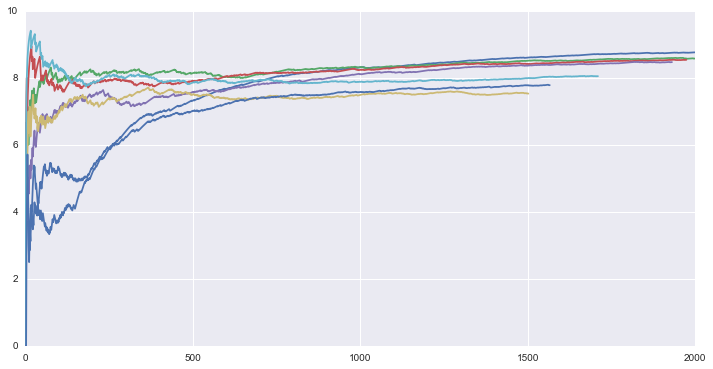

In [2]:
from __future__ import division
import argparse
import json
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))

log = ['dqn_mc_mat-v1_log.json', 'dqn_log_0315_172505.json', 'dqn_log_0315_174448.json', 'dqn_log_0315_182836.json','dqn_log_0316_104020.json','dqn_log_0316_104556.json','dqn_log_0316_105131.json']

for i in log:
    filename = i
    with open(filename, 'r') as f:
        data = json.load(f)

    episodes = data['episode']
    keys = sorted(list(set(data.keys()).difference(set(['episode']))))
    reward = data['episode_reward']
#     reward = np.array(data['episode_reward'])/np.array(data['nb_episode_steps'])
    
    reward_mean = [sum(reward[:index])/(index+1) for index in range(len(reward))]
#     reward_mean = np.convolve(reward, np.ones(50)/50)
    fig = plt.plot(episodes[:2000],reward_mean[:2000]);
plt.ylim(None,10);

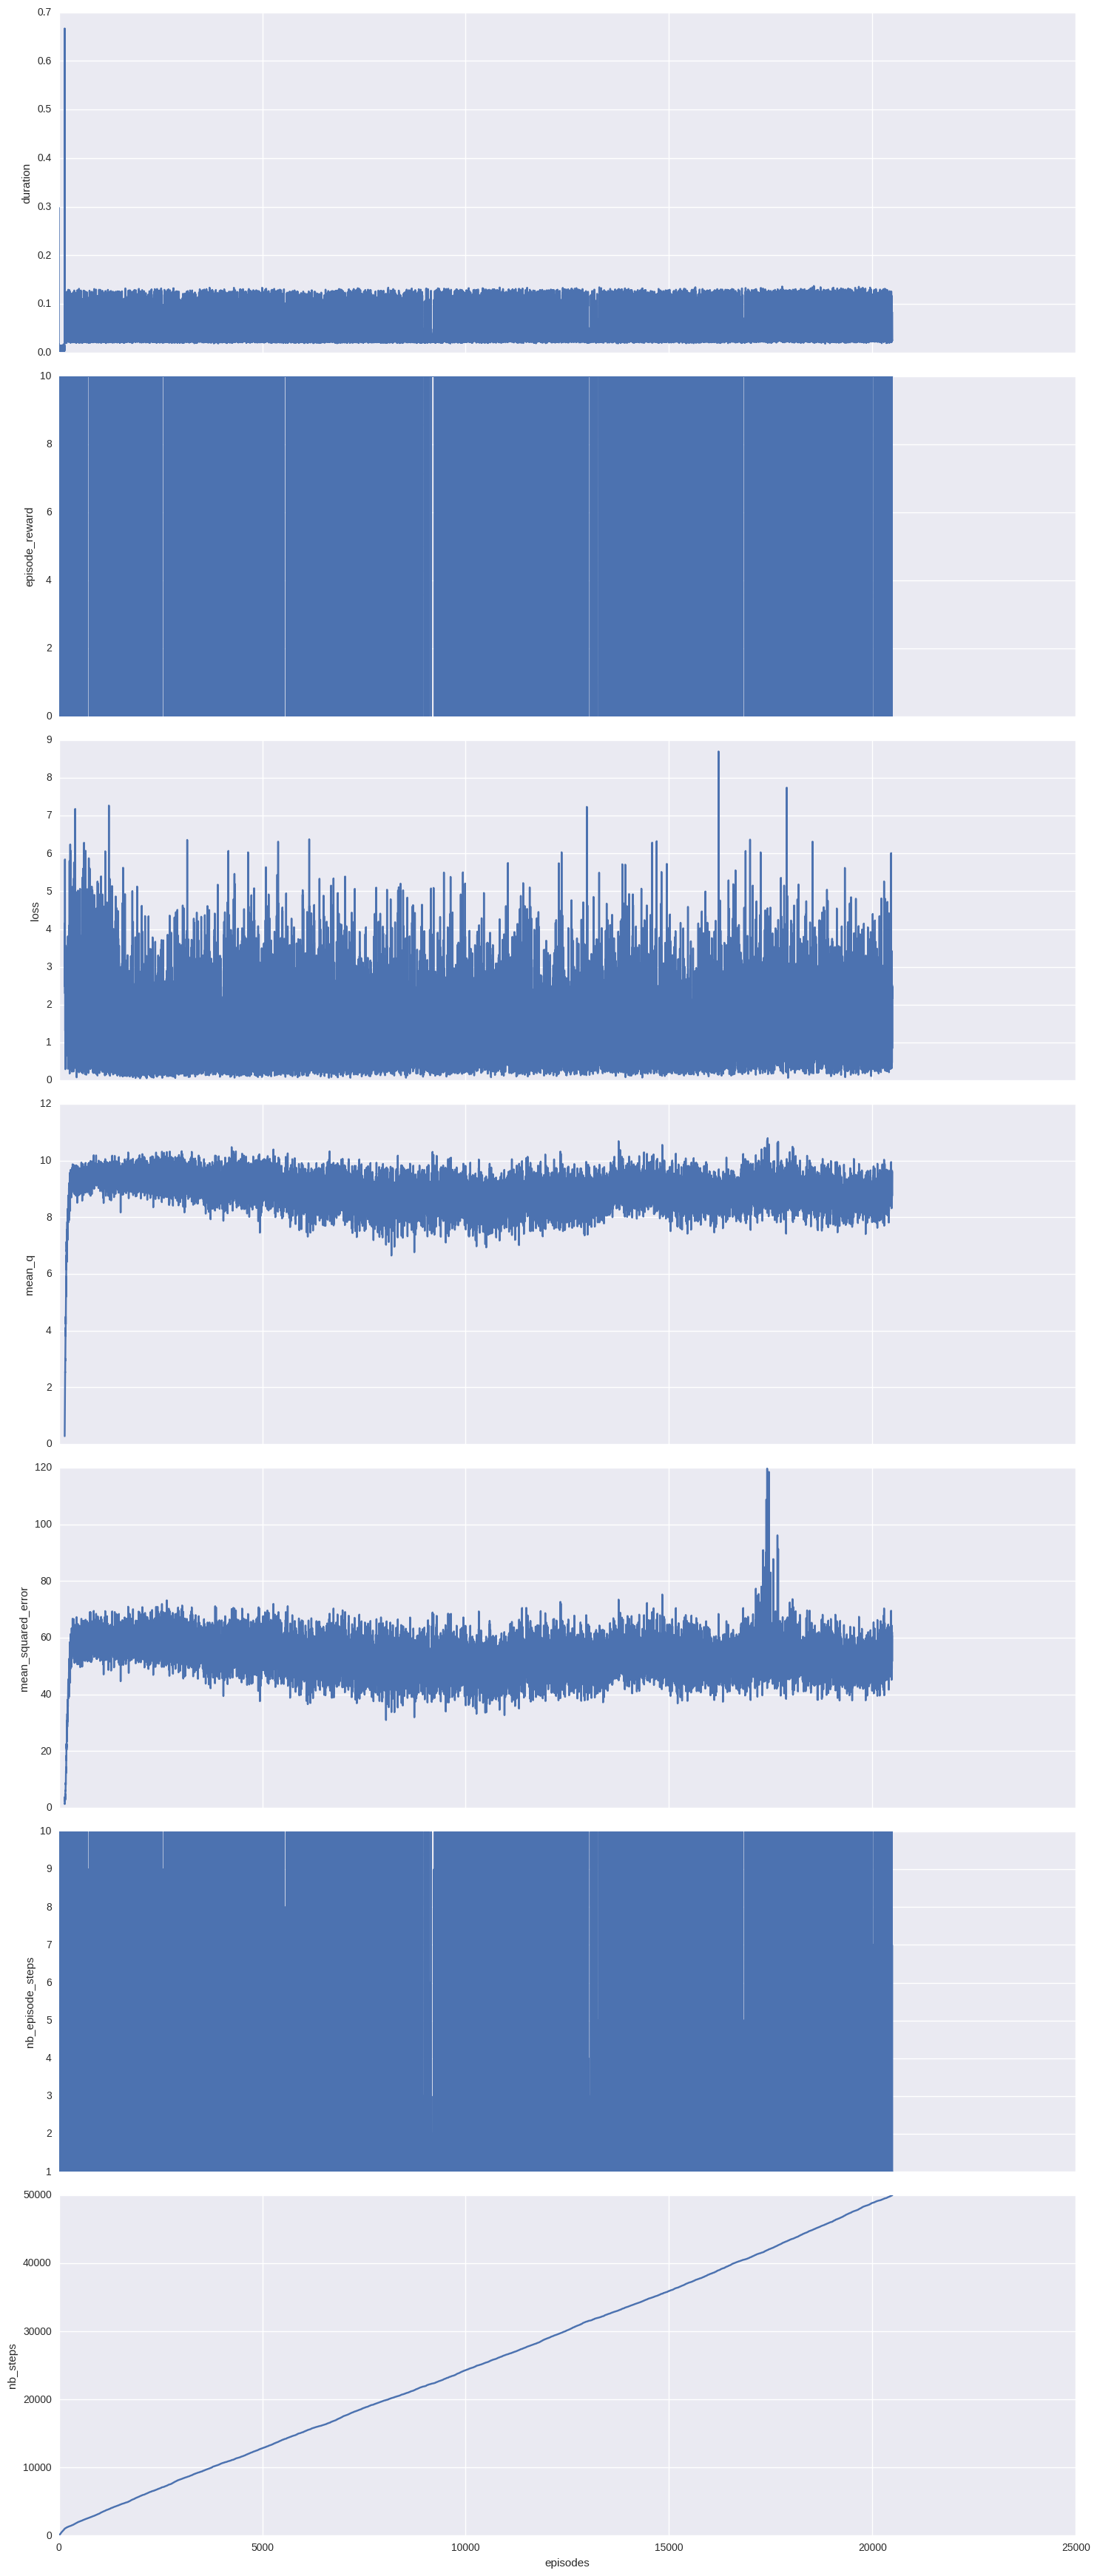

In [3]:
import argparse
import json
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# sns.set_style('whitegrid')

def visualize_log(filename, figsize=None, output=None):
    with open(filename, 'r') as f:
        data = json.load(f)
    if 'episode' not in data:
        raise ValueError('Log file "{}" does not contain the "episode" key.'.format(filename))
    episodes = data['episode']

    # Get value keys. The x axis is shared and is the number of episodes.
    keys = sorted(list(set(data.keys()).difference(set(['episode']))))

    if figsize is None:
        figsize = (15., 5. * len(keys))
    f, axarr = plt.subplots(len(keys), sharex=True, figsize=figsize)
    for idx, key in enumerate(keys):
        axarr[idx].plot(episodes, data[key])
        axarr[idx].set_ylabel(key)
    plt.xlabel('episodes')
    plt.tight_layout()
    if output is None:
        plt.show()
    else:
        plt.savefig(output)


# parser = argparse.ArgumentParser()
# parser.add_argument('filename', type=str, help='The filename of the JSON log generated during training.')
# parser.add_argument('--output', type=str, default=None, help='The output file. If not specified, the log will only be displayed.')
# parser.add_argument('--figsize', nargs=2, type=float, default=None, help='The size of the figure in `width height` format specified in points.')
# args = parser.parse_args()

# You can use visualize_log to easily view the stats that were recorded during training. Simply
# provide the filename of the `FileLogger` that was used in `FileLogger`.
visualize_log(log_filename)

[u'duration', u'episode_reward', u'loss', u'mean_q', u'mean_squared_error', u'nb_episode_steps', u'nb_steps']


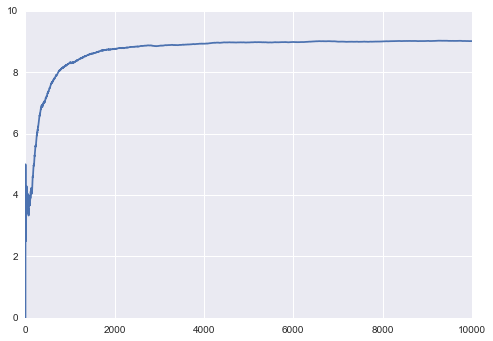

In [14]:
from __future__ import division
import argparse
import json
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('darkgrid')
log_filename='dqn_mc_mat-v1_log.json'
filename = log_filename
with open(filename, 'r') as f:
    data = json.load(f)

episodes = data['episode']

# Get value keys. The x axis is shared and is the number of episodes.
keys = sorted(list(set(data.keys()).difference(set(['episode']))))
print keys
reward = data['episode_reward']
reward_mean = [sum(reward[:index])/(index+1) for index in range(len(reward))]
plt.plot(episodes[:10000],reward_mean[:10000])

[u'duration', u'episode_reward', u'loss', u'mean_q', u'mean_squared_error', u'nb_episode_steps', u'nb_steps']


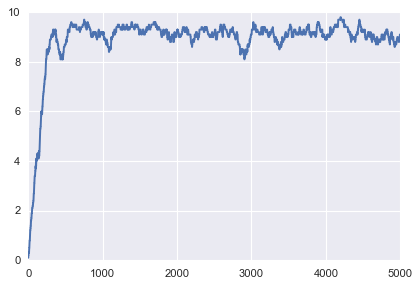

In [129]:
from __future__ import division
import numpy as np
# %matplotlib inline
# sns.set_style('whitegrid')

filename = log_filename
with open(filename, 'r') as f:
    data = json.load(f)

episodes = data['episode']

# Get value keys. The x axis is shared and is the number of episodes.
keys = sorted(list(set(data.keys()).difference(set(['episode']))))
print keys
reward = data['episode_reward']
smoothed = np.convolve(reward, np.ones(100)/100)

# reward_mean = [sum(reward[:index])/(index+1) for index in range(len(reward))]
plt.plot(episodes[:5000],smoothed[:5000]);




[u'duration', u'episode_reward', u'loss', u'mean_q', u'mean_squared_error', u'nb_episode_steps', u'nb_steps']


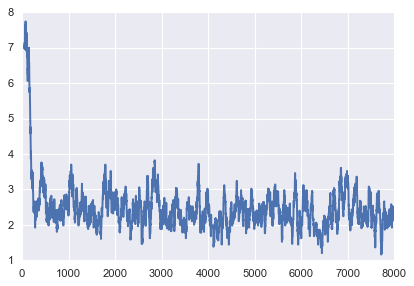

In [130]:
from __future__ import division
filename = log_filename
with open(filename, 'r') as f:
    data = json.load(f)

episodes = data['episode']

# Get value keys. The x axis is shared and is the number of episodes.
keys = sorted(list(set(data.keys()).difference(set(['episode']))))
print keys
reward = data['nb_episode_steps']
# reward_mean = [sum(reward[:index])/(index+1) for index in range(len(reward))]
reward_mean = np.convolve(reward, np.ones(50)/50)

plt.plot(episodes[50:8000],reward_mean[50:8000])

[u'duration', u'episode_reward', u'loss', u'mean_q', u'mean_squared_error', u'nb_episode_steps', u'nb_steps']


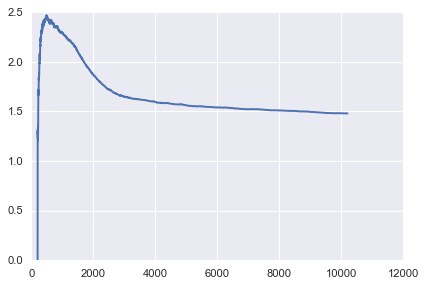

In [131]:
filename = log_filename
with open(filename, 'r') as f:
    data = json.load(f)

episodes = data['episode'][200:]

# Get value keys. The x axis is shared and is the number of episodes.
keys = sorted(list(set(data.keys()).difference(set(['episode']))))
print keys
reward = data['loss'][200:]
reward_mean = [sum(reward[:index])/(index+1) for index in range(len(reward))]
plt.plot(episodes[:10000],reward_mean[:10000])

[u'duration', u'episode_reward', u'loss', u'mean_q', u'mean_squared_error', u'nb_episode_steps', u'nb_steps']


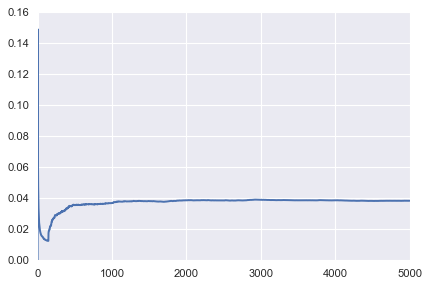

In [132]:
from __future__ import division
filename = log_filename
with open(filename, 'r') as f:
    data = json.load(f)

episodes = data['episode']

# Get value keys. The x axis is shared and is the number of episodes.
keys = sorted(list(set(data.keys()).difference(set(['episode']))))
print keys
reward = data['duration']
reward_mean = [sum(reward[:index])/(index+1) for index in range(len(reward))]
# reward_mean = np.convolve(reward, np.ones(20)/20)

plt.plot(episodes[:5000],reward_mean[:5000])

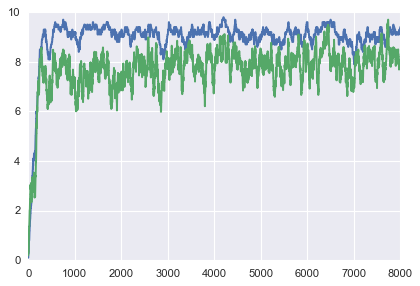

In [133]:
reward = data['episode_reward']
smoothed = np.convolve(reward, np.ones(100)/100)
# reward_mean = [sum(reward[:index])/(index+1) for index in range(len(reward))]
plt.plot(episodes[:8000],smoothed[:8000]);

reward = data['episode_reward']
steps = data['nb_episode_steps']
re_stp = np.array(reward)/np.array(steps)
re_stp = np.convolve(re_stp, np.ones(50)/50)
plt.plot(episodes[:8000],re_stp[:8000]);

In [63]:
import pandas as pd
import random
a = pd.read_csv('train5000.csv')
nrow = random.randint(0,a.shape[0])
b = a.loc[nrow,'esb']
print b
# for i in b[1:-1]:
#     print i
    
    

b=map(float, b[1:-1].split(", "))
print type(b)
# map(int, words)

[6.55918, 8.38011, 9.76248, 10.1422]
<type 'list'>


In [64]:
a.loc[nrow,'esb']#[1:-1].split(", ")

'[6.55918, 8.38011, 9.76248, 10.1422]'

In [65]:
map(float, a.loc[nrow,'esb'][1:-1].split(", "))

[6.55918, 8.38011, 9.76248, 10.1422]

In [19]:
def onehot(observation,min,max,n=10):
    my_onehot = np.zeros((n))
    value = observation//((max-min)/float(n))
    my_onehot[int(value)] = 1.0
    
    return my_onehot

aaa = onehot(64,0.1,72)
bbb = onehot(14,0.1,72)
aaa
bbb

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.])

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [22]:
import numpy as np
gg = np.concatenate((aaa,bbb,aaa),axis=0)
print gg
print tuple(gg)

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)


In [19]:
a=[1,2,3]
b=[2,1,4]
xyz = [a,b]
xyz = zip(*[a,b])
map(max, zip(*[a,b]))
# np.array(a)/np.array(b)

[2, 2, 4]

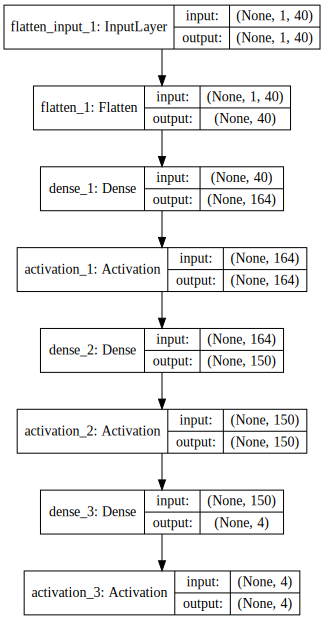

In [29]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

fig = SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))
fig